In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
import sklearn
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
# Import Libraries #
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # matplotlib for plotting
import seaborn as sns  # seaborn to help with visualizations
from subprocess import check_output  # check files in directory

In [3]:
sc = SparkContext()

In [4]:
spark = SparkSession.builder.appName('ufo').getOrCreate()

In [5]:
spark

In [6]:
ufo = spark.read.csv('archive/scrubbed.csv', header=True)

In [7]:
ufo.printSchema()

root
 |-- datetime: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- shape: string (nullable = true)
 |-- duration (seconds): string (nullable = true)
 |-- duration (hours/min): string (nullable = true)
 |-- comments: string (nullable = true)
 |-- date posted: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude : string (nullable = true)



In [8]:
ufo.count()

80332

In [9]:
ufo.show()

+----------------+--------------------+-----+-------+--------+------------------+--------------------+--------------------+-----------+----------+------------+
|        datetime|                city|state|country|   shape|duration (seconds)|duration (hours/min)|            comments|date posted|  latitude|  longitude |
+----------------+--------------------+-----+-------+--------+------------------+--------------------+--------------------+-----------+----------+------------+
|10/10/1949 20:30|          san marcos|   tx|     us|cylinder|              2700|          45 minutes|This event took p...|  4/27/2004|29.8830556| -97.9411111|
|10/10/1949 21:00|        lackland afb|   tx|   null|   light|              7200|             1-2 hrs|1949 Lackland AFB...| 12/16/2005|  29.38421|  -98.581082|
|10/10/1955 17:00|chester (uk/england)| null|     gb|  circle|                20|          20 seconds|Green/Orange circ...|  1/21/2008|      53.2|   -2.916667|
|10/10/1956 21:00|                edna| 

In [10]:
ufo.columns

['datetime',
 'city',
 'state',
 'country',
 'shape',
 'duration (seconds)',
 'duration (hours/min)',
 'comments',
 'date posted',
 'latitude',
 'longitude ']

In [11]:
ufo.describe()

DataFrame[summary: string, datetime: string, city: string, state: string, country: string, shape: string, duration (seconds): string, duration (hours/min): string, comments: string, date posted: string, latitude: string, longitude : string]

In [12]:
from pyspark.sql.functions import isnan, when, count, col

### Checking for NAN values

In [13]:
ufo.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ufo.columns]).show()

+--------+----+-----+-------+-----+------------------+--------------------+--------+-----------+--------+----------+
|datetime|city|state|country|shape|duration (seconds)|duration (hours/min)|comments|date posted|latitude|longitude |
+--------+----+-----+-------+-----+------------------+--------------------+--------+-----------+--------+----------+
|       0|   0| 5797|   9670| 1932|                 0|                   0|      15|          0|       0|         0|
+--------+----+-----+-------+-----+------------------+--------------------+--------+-----------+--------+----------+



In [14]:
ufo.na.fill("").show()

+----------------+--------------------+-----+-------+--------+------------------+--------------------+--------------------+-----------+----------+------------+
|        datetime|                city|state|country|   shape|duration (seconds)|duration (hours/min)|            comments|date posted|  latitude|  longitude |
+----------------+--------------------+-----+-------+--------+------------------+--------------------+--------------------+-----------+----------+------------+
|10/10/1949 20:30|          san marcos|   tx|     us|cylinder|              2700|          45 minutes|This event took p...|  4/27/2004|29.8830556| -97.9411111|
|10/10/1949 21:00|        lackland afb|   tx|       |   light|              7200|             1-2 hrs|1949 Lackland AFB...| 12/16/2005|  29.38421|  -98.581082|
|10/10/1955 17:00|chester (uk/england)|     |     gb|  circle|                20|          20 seconds|Green/Orange circ...|  1/21/2008|      53.2|   -2.916667|
|10/10/1956 21:00|                edna| 

In [15]:
ufo

DataFrame[datetime: string, city: string, state: string, country: string, shape: string, duration (seconds): string, duration (hours/min): string, comments: string, date posted: string, latitude: string, longitude : string]

###  Convert datetime string to datetime

In [16]:
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import from_unixtime

# df2 = ufo.select('datetime', from_unixtime(unix_timestamp('datetime', 'MM/dd/yyy HH:MM')).alias('date'))

# df2

# df2.show()

In [17]:
from pyspark.sql.functions import desc
ufo.groupby('shape').count().sort(desc('count')).show()

+---------+-----+
|    shape|count|
+---------+-----+
|    light|16565|
| triangle| 7865|
|   circle| 7608|
| fireball| 6208|
|    other| 5649|
|  unknown| 5584|
|   sphere| 5387|
|     disk| 5213|
|     oval| 3733|
|formation| 2457|
|    cigar| 2057|
| changing| 1962|
|     null| 1932|
|    flash| 1328|
|rectangle| 1297|
| cylinder| 1283|
|  diamond| 1178|
|  chevron|  952|
|      egg|  759|
| teardrop|  750|
+---------+-----+
only showing top 20 rows



In [18]:
for ufo_cols in ufo.columns:
    print(f"Colname: {ufo_cols}")
    ufo.groupby(ufo_cols).count().sort(desc('count')).show()

Colname: datetime
+----------------+-----+
|        datetime|count|
+----------------+-----+
|  7/4/2010 22:00|   36|
|  7/4/2012 22:00|   31|
|11/16/1999 19:00|   27|
| 9/19/2009 20:00|   26|
|  7/4/2011 22:00|   25|
|  7/4/2010 21:00|   23|
|10/31/2004 20:00|   23|
|  7/4/2013 22:00|   22|
|  7/4/2012 22:30|   21|
|11/16/1999 18:05|   20|
|  7/4/2013 22:30|   20|
|11/16/1999 19:05|   20|
|  7/4/2010 23:00|   20|
| 9/19/2009 19:50|   19|
| 9/30/2005 23:00|   18|
|  7/4/2010 22:30|   18|
|  7/4/2010 21:30|   18|
|  9/1/1999 21:30|   18|
|  7/4/2012 21:30|   18|
|  1/1/2014 00:00|   16|
+----------------+-----+
only showing top 20 rows

Colname: city
+-------------------+-----+
|               city|count|
+-------------------+-----+
|            seattle|  525|
|            phoenix|  454|
|           portland|  374|
|          las vegas|  368|
|        los angeles|  353|
|          san diego|  338|
|            houston|  297|
|            chicago|  265|
|             tucson|  241|
|     

### convert data types

In [19]:
from pyspark.sql.types import IntegerType
list_cols = ['duration (seconds)', 'latitude', 'longitude']

In [20]:
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.types import TimestampType

ufo = ufo.withColumn("duration (seconds)", ufo['duration (seconds)'].cast('float'))
ufo = ufo.withColumn("latitude", ufo.latitude.cast('float'))
ufo = ufo.withColumn("longitude ", ufo['longitude '].cast('float'))
# ufo = ufo.withColumn("datetime",unix_timestamp("datetime", 'MM/dd/yyyy HH:mm').cast(TimestampType()))

In [21]:
ufo.printSchema()

root
 |-- datetime: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- shape: string (nullable = true)
 |-- duration (seconds): float (nullable = true)
 |-- duration (hours/min): string (nullable = true)
 |-- comments: string (nullable = true)
 |-- date posted: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude : float (nullable = true)



In [22]:
from pyspark.sql.types import DateType
# ufo = ufo.withColumn("datetime", ufo['datetime'].cast(DateType()))
# ufo = ufo.withColumn("date posted",ufo['date posted'].cast(DateType()))

#below is the result
# ufo.select('datetime').show(10)

In [23]:
# ufo['date posted'].collect()
# ufo[ufo['date posted']].take(2)
ufo.select("datetime").show()

+----------------+
|        datetime|
+----------------+
|10/10/1949 20:30|
|10/10/1949 21:00|
|10/10/1955 17:00|
|10/10/1956 21:00|
|10/10/1960 20:00|
|10/10/1961 19:00|
|10/10/1965 21:00|
|10/10/1965 23:45|
|10/10/1966 20:00|
|10/10/1966 21:00|
|10/10/1968 13:00|
|10/10/1968 19:00|
|10/10/1970 16:00|
|10/10/1970 19:00|
|10/10/1971 21:00|
|10/10/1972 19:00|
|10/10/1972 22:30|
|10/10/1973 19:00|
|10/10/1973 23:00|
|10/10/1974 19:30|
+----------------+
only showing top 20 rows



In [24]:
from pyspark.sql import functions as F

# ufo = ufo.withColumn(
#             'datetime',
#                 F.to_date(
#                     F.unix_timestamp('datetime', 'MM-dd-yyyy HH:mm').cast('timestamp'))).show()

### convert to datetime

In [25]:
ufo.select('datetime').show()

+----------------+
|        datetime|
+----------------+
|10/10/1949 20:30|
|10/10/1949 21:00|
|10/10/1955 17:00|
|10/10/1956 21:00|
|10/10/1960 20:00|
|10/10/1961 19:00|
|10/10/1965 21:00|
|10/10/1965 23:45|
|10/10/1966 20:00|
|10/10/1966 21:00|
|10/10/1968 13:00|
|10/10/1968 19:00|
|10/10/1970 16:00|
|10/10/1970 19:00|
|10/10/1971 21:00|
|10/10/1972 19:00|
|10/10/1972 22:30|
|10/10/1973 19:00|
|10/10/1973 23:00|
|10/10/1974 19:30|
+----------------+
only showing top 20 rows



In [26]:
from pyspark.sql.functions import *
# df=spark.createDataFrame([["02-03-2013"],["05-06-2023"]],["input"])
# ufo.select(col("datetime"),to_date(col("datetime"),"MM-dd-yyyy HH:MM").alias("date")) \
#   .show()

### replace column name

In [27]:
from pyspark.sql.functions import when

ufo = ufo.withColumnRenamed("longitude ","longitude")

### filtering rows on latitude and longitude

In [28]:
# ufo = ufo[(ufo.latitude > 50) & (ufo.longitude < -65)]

In [29]:
ufo = ufo[(ufo.latitude > 50) & (ufo.longitude > -125) == False]

In [30]:
ufo.show()

+----------------+----------------+-----+-------+--------+------------------+--------------------+--------------------+-----------+---------+----------+
|        datetime|            city|state|country|   shape|duration (seconds)|duration (hours/min)|            comments|date posted| latitude| longitude|
+----------------+----------------+-----+-------+--------+------------------+--------------------+--------------------+-----------+---------+----------+
|10/10/1949 20:30|      san marcos|   tx|     us|cylinder|            2700.0|          45 minutes|This event took p...|  4/27/2004|29.883055| -97.94111|
|10/10/1949 21:00|    lackland afb|   tx|   null|   light|            7200.0|             1-2 hrs|1949 Lackland AFB...| 12/16/2005| 29.38421|-98.581085|
|10/10/1956 21:00|            edna|   tx|     us|  circle|              20.0|            1/2 hour|My older brother ...|  1/17/2004|28.978333|-96.645836|
|10/10/1960 20:00|         kaneohe|   hi|     us|   light|             900.0|     

In [31]:
ufo.select('city').show()

+----------------+
|            city|
+----------------+
|      san marcos|
|    lackland afb|
|            edna|
|         kaneohe|
|         bristol|
|         norwalk|
|       pell city|
|        live oak|
|       hawthorne|
|         brevard|
|        bellmore|
|      manchester|
|       lexington|
|   harlan county|
| west bloomfield|
|         niantic|
|     bermuda nas|
|          hudson|
|          hudson|
|north charleston|
+----------------+
only showing top 20 rows



In [32]:
from pyspark.sql.functions import count, avg

# ufo.filter(ufo.city == 'fairbanks').count()
# ufo.groupBy(['city', 'duration']).count().orderBy('count').show()
# ufo.groupBy("city", "duration (seconds)").agg(avg("percent"), count("*"))


In [33]:
from pyspark.sql.functions import collect_list
grouping_cols = ["city", "duration (seconds)"]
other_cols = [c for c in ufo.columns if c not in grouping_cols]
# ufo.groupBy(grouping_cols).agg(*[collect_list(c).alias(c) for c in other_cols]).show()

In [34]:
ufo.groupBy('country').count().orderBy('count').show()

+-------+-----+
|country|count|
+-------+-----+
|     de|   42|
|     au|  538|
|     ca| 2488|
|   null| 8627|
|     us|65114|
+-------+-----+



In [35]:
ufo.na#.fill(50).show()

In [36]:
ufo.where(col("city").isNull())

DataFrame[datetime: string, city: string, state: string, country: string, shape: string, duration (seconds): float, duration (hours/min): string, comments: string, date posted: string, latitude: float, longitude: float]

In [37]:
ufo

DataFrame[datetime: string, city: string, state: string, country: string, shape: string, duration (seconds): float, duration (hours/min): string, comments: string, date posted: string, latitude: float, longitude: float]

In [38]:
from pyspark.sql import SQLContext

In [39]:
for cols in ufo.columns:
    try:
        print({cols: ufo.filter(ufo[cols].isNull()).count()})
    except:
        pass

{'datetime': 0}
{'city': 0}
{'state': 2935}
{'country': 8627}
{'shape': 1850}
{'duration (seconds)': 3}
{'duration (hours/min)': 0}
{'comments': 15}
{'date posted': 0}
{'latitude': 0}
{'longitude': 0}


In [40]:
ufo.dropna(how='any').show()

+----------------+----------------+-----+-------+--------+------------------+--------------------+--------------------+-----------+---------+----------+
|        datetime|            city|state|country|   shape|duration (seconds)|duration (hours/min)|            comments|date posted| latitude| longitude|
+----------------+----------------+-----+-------+--------+------------------+--------------------+--------------------+-----------+---------+----------+
|10/10/1949 20:30|      san marcos|   tx|     us|cylinder|            2700.0|          45 minutes|This event took p...|  4/27/2004|29.883055| -97.94111|
|10/10/1956 21:00|            edna|   tx|     us|  circle|              20.0|            1/2 hour|My older brother ...|  1/17/2004|28.978333|-96.645836|
|10/10/1960 20:00|         kaneohe|   hi|     us|   light|             900.0|          15 minutes|AS a Marine 1st L...|  1/22/2004|21.418056| -157.8036|
|10/10/1961 19:00|         bristol|   tn|     us|  sphere|             300.0|     

In [41]:
ufo_data = ufo.toPandas()
df = ufo.toPandas()

In [42]:
nulvals = df.isnull().sum()
nulpct = (nulvals / len(df))*100
print('Null Values (% of entries):')
print(nulpct)

Null Values (% of entries):
datetime                 0.000000
city                     0.000000
state                    3.821167
country                 11.231757
shape                    2.408572
duration (seconds)       0.003906
duration (hours/min)     0.000000
comments                 0.019529
date posted              0.000000
latitude                 0.000000
longitude                0.000000
dtype: float64


In [43]:
ufo_data = pd.read_csv('archive/scrubbed.csv', 
                        low_memory = False, 
                        na_values = ['UNKNOWN','UNK'], 
                        na_filter = True, 
                        skip_blank_lines = True)  # load dataset without NA values

# Choose columns to work with based on our initial questions
ufo_subcols = ['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
        'comments', 'date posted', 'latitude',
       'longitude ']

# After tidying data and choosing what to work with, create dataframe to work with
ufo_data = pd.DataFrame(data=ufo_data, columns=ufo_subcols)

# ...drop null values
ufo_data = ufo_data.dropna(thresh=8)

#...reset the index
ufo_data = ufo_data.reset_index(drop=True)

# EXTRACT LATITUDES #
ufo_data['latitude'] = pd.to_numeric(ufo_data['latitude'],errors = 'coerce')  # latitudes as numerics
ufo_data['longitude '] = pd.to_numeric(ufo_data['longitude '], errors='coerce')

# CHANGE VARIABLES UFO_DATE IN SCRIPT 1-1-18
ufo_date = ufo_data.datetime.str.replace('24:00', '00:00')  # clean illegal values
ufo_date = pd.to_datetime(ufo_date, format='%m/%d/%Y %H:%M')  # now in datetime

ufo_data['datetime'] = ufo_data.datetime.str.replace('24:00', '00:00')
ufo_data['datetime'] = pd.to_datetime(ufo_data['datetime'], format='%m/%d/%Y %H:%M')

In [44]:
df.shape

(76809, 11)

In [45]:
ufo_data

datetime                  city state country     shape  \
0     1949-10-10 20:30:00            san marcos    tx      us  cylinder   
1     1949-10-10 21:00:00          lackland afb    tx     NaN     light   
2     1955-10-10 17:00:00  chester (uk/england)   NaN      gb    circle   
3     1956-10-10 21:00:00                  edna    tx      us    circle   
4     1960-10-10 20:00:00               kaneohe    hi      us     light   
...                   ...                   ...   ...     ...       ...   
80252 2013-09-09 21:15:00             nashville    tn      us     light   
80253 2013-09-09 22:00:00                 boise    id      us    circle   
80254 2013-09-09 22:00:00                  napa    ca      us     other   
80255 2013-09-09 22:20:00                vienna    va      us    circle   
80256 2013-09-09 23:00:00                edmond    ok      us     cigar   

      duration (seconds)                                           comments  \
0                   2700  This event took place in early fall around 194...   
1                   7200  1949 Lackland AFB&#44 TX.  Lights racing acros...   
2                     20  Green/Orange circular disc over Chester&#44 En...   
3                     20  My older brother and twin sister were leaving ...   
4                    900  AS a Marine 1st Lt. flying an FJ4B fighter/att...   
...                  ...                                                ...   
80252                600  Round from the distance/slowly changing colors...   
80253               1200  Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...   
80254               1200                                       Napa UFO&#44   
80255                  5  Saw a five gold lit cicular craft moving fastl...   
80256               1020  2 witnesses 2  miles apart&#44 Red &amp; White...   

      date posted   latitude  longitude   
0       4/27/2004  29.883056  -97.941111  
1      12/16/2005  29.384210  -98.581082  
2       1/21/2008  53.200000   -2.916667  
3       1/17/2004  28.978333  -96.645833  
4       1/22/2004  21.418056 -157.803611  
...           ...        ...         ...  
80252   9/30/2013  36.165833  -86.784444  
80253   9/30/2013  43.613611 -116.202500  
80254   9/30/2013  38.297222 -122.284444  
80255   9/30/2013  38.901111  -77.265556  
80256   9/30/2013  35.652778  -97.477778  

[80257 rows x 10 columns]

In [46]:
ufo_data.dtypes

datetime              datetime64[ns]
city                          object
state                         object
country                       object
shape                         object
duration (seconds)            object
comments                      object
date posted                   object
latitude                     float64
longitude                    float64
dtype: object

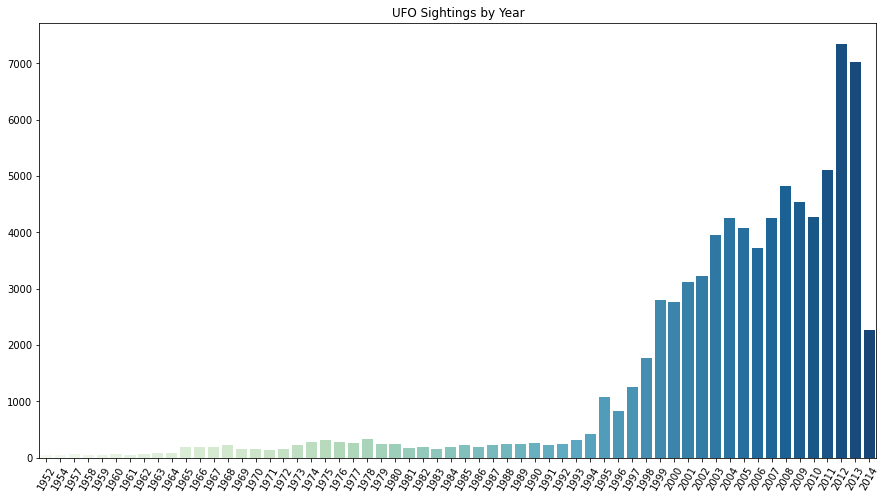

In [47]:
ufo_yr = ufo_date.dt.year  # series with the year exclusively

## Set axes ##
years_data = ufo_yr.value_counts()
years_index = years_data.index  # x ticks
years_values = years_data.values

## Create Bar Plot ##
plt.figure(figsize=(15,8))
plt.xticks(rotation = 60)
plt.title('UFO Sightings by Year')

years_plot = sns.barplot(x=years_index[:60],y=years_values[:60], palette = "GnBu")

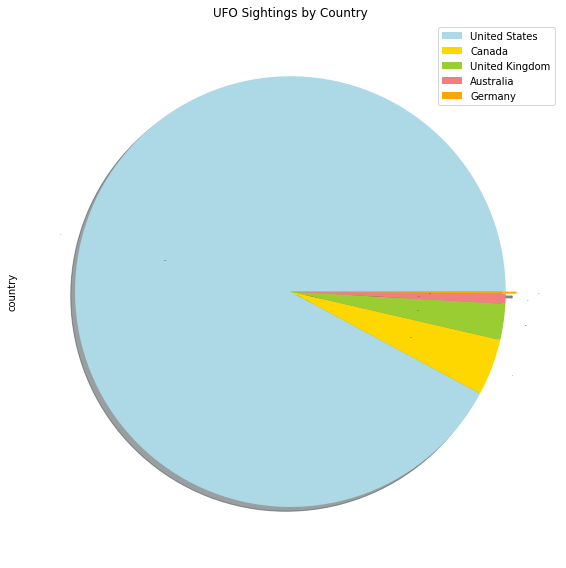

In [48]:
country_sightings = ufo_data.country.value_counts()  # num ufo sightings per country 

explode = (0, 0, 0, 0., 0.05)
colors = ['lightblue','gold','yellowgreen','lightcoral','orange']
country_sightings.plot(kind = 'pie', fontsize = 0, title='UFO Sightings by Country', colors=colors,
                       autopct='%1.1f%%',shadow=True, explode=explode,figsize=(8,8))
plt.legend(labels=['United States','Canada','United Kingdom','Australia','Germany'], loc="best")
plt.tight_layout()

In [49]:
ufo_data['country'].value_counts().head(10)

us    65114
ca     3000
gb     1905
au      538
de      105
Name: country, dtype: int64

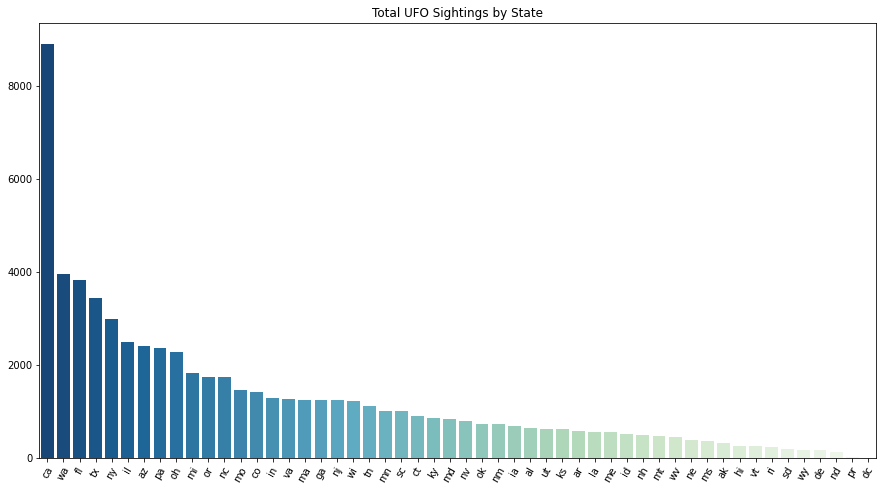

Top 10 States for Total UFO Sightings:
ca    8912
wa    3966
fl    3835
tx    3447
ny    2980
il    2499
az    2414
pa    2366
oh    2275
mi    1836
Name: state, dtype: int64


In [50]:
# Filter US Values to analyze US state sightings #
usa_filter = ufo_data['country']=='us'  # filter non-usa country
us_data = ufo_data[usa_filter]  # DF ufo_data of only US sightings - includes puerto rico and dc

# Get x and y axes for states bar viz #
states_sights = us_data.state.value_counts()  # State Data
state_names = states_sights.index  # x axis ticks
state_freq = states_sights.values  # y axis values

# States Frequency Pareto Chart #
plt.figure(figsize=(15,8))
plt.xticks(rotation = 60)
plt.title('Total UFO Sightings by State')
states_plot = sns.barplot(x=state_names,y=state_freq, palette="GnBu_r")
plt.show()
print('Top 10 States for Total UFO Sightings:')
print(states_sights[:10].sort_values(ascending=False))

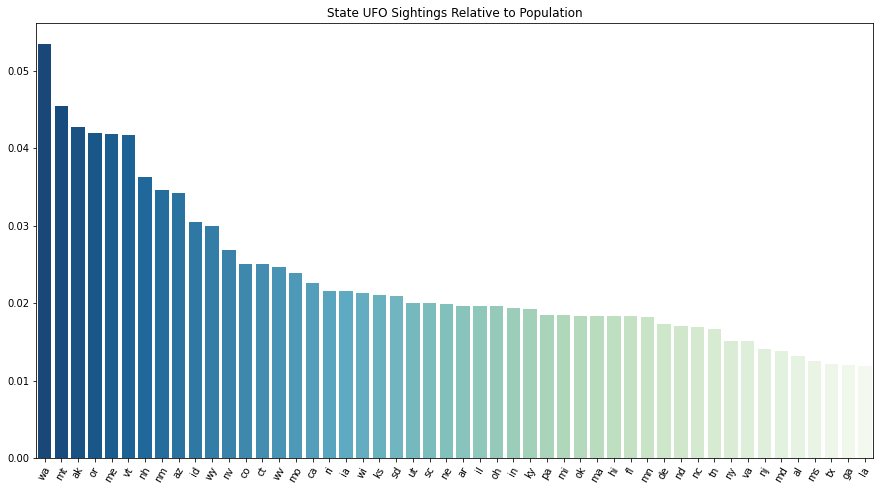

States with Highest Proportion of UFO Sightings:
wa    0.053481
mt    0.045396
ak    0.042757
or    0.041972
me    0.041845
vt    0.041727
nh    0.036283
nm    0.034587
az    0.034267
id    0.030406
dtype: float64 2


In [51]:
statespop = {'al':4872725.,'ak':746079.,'az':7044577.,'ar':2998643.,'ca':39506094.,
            'co':5632271.,'ct':3568174.,'de':960054.,'dc':691963.,'fl':20979964.,
            'ga':10421344.,'hi':1431957.,'id':1713452.,'il':12764031.,'in':6653338.,
            'ia':3147389.,'ks':2907857.,'ky':4449337.,'la':4694372.,'me':1333505.,
            'md':6037911.,'ma':6839318.,'mi':9938885.,'mn':5557469.,'ms':2988062.,
            'mo':6109796.,'mt':1052967.,'ne':1920467.,'nv':2996358,'nh':1339479.,
            'nj':8953517.,'nm':2081702.,'ny':19743395.,'nc':10258390.,'nd':759069.,
            'oh':11623656.,'ok':3939708.,'or':4162296.,'pa':12776550.,'pr':3661538.,
            'ri':1057245.,'sc':5027404.,'sd':872989.,'tn':6707332.,'tx':28295553.,
            'ut':3111802.,'vt':623100.,'va':8456029.,'wa':7415710.,'wv':1821151.,
            'wi':5789525.,'wy':584447.} 
states_pop = pd.Series(statespop)  # turn dict into series type


state_propsight = (states_sights / states_pop)*100 # prop data series for viz, scaled for style
state_propsight = state_propsight.sort_values(ascending=False) 

# Visualize it
us_namesp = state_propsight.index  # x ticks
us_sightsp = state_propsight.values  # y values

plt.figure(figsize=(15,8))
plt.xticks(rotation=60)
plt.title('State UFO Sightings Relative to Population')
sns.barplot(x = us_namesp[:50], y = us_sightsp[:50], palette="GnBu_r")
plt.show()
print('States with Highest Proportion of UFO Sightings:')
print(state_propsight[:10],2)

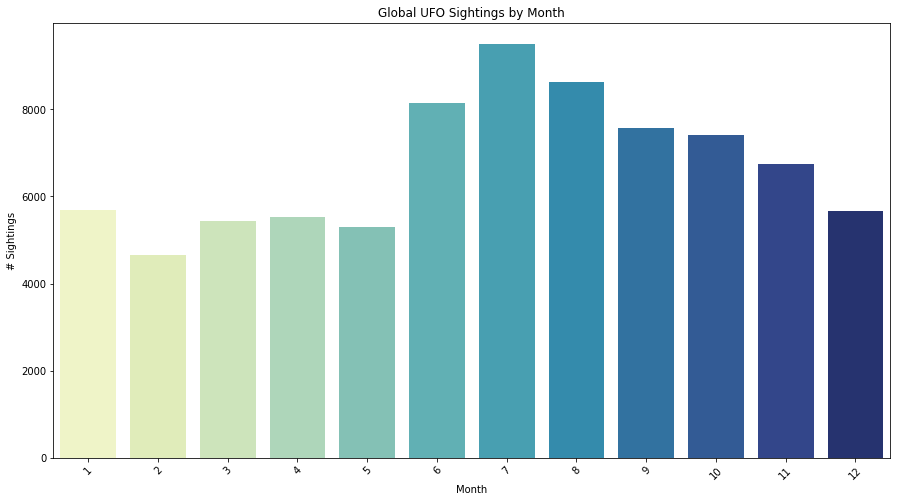

In [52]:
m_cts = (ufo_data['datetime'].dt.month.value_counts()).sort_index()
m_ctsx = m_cts.index
m_ctsy = m_cts.values
f, ax = plt.subplots(figsize=(15,8))

sns.barplot(x=m_ctsx, y=m_ctsy, palette="YlGnBu")
ax.set_title('Global UFO Sightings by Month')
ax.set_xlabel('Month')
ax.set_ylabel('# Sightings')
plt.xticks(rotation=45)
plt.show()

In [53]:
# Add Season Column to ufo_date #
# Given a datetime, return the season that it's in #
ufo_datem = ufo_date.dt.month
spring = range(5,7)
summer = range(7,10)
fall = range(10,12)
seasons = []

for st_date in ufo_datem:
    # Conversion Process # 
    if st_date in spring:
        seasons.append('Spring')
    elif st_date in summer:
        seasons.append('Summer')
    elif st_date in fall:
        seasons.append('Fall')
    else:
        seasons.append('Winter')
ufo_data['season'] = pd.Series(seasons, index=ufo_data.index)

In [54]:
# Add Hemisphere Column to ufo_date #
hemis = []
for st_loc in ufo_data['latitude']:
    if st_loc >= 0 :
        hemis.append('Northern Hemisphere')
    else:
        hemis.append('Southern Hemisphere')

In [55]:
ufo_data['hemisphere'] = (pd.Series(hemis, index=ufo_data.index)).astype('category')
ufo_data['season'].value_counts()

Winter    26971
Summer    25719
Fall      14142
Spring    13425
Name: season, dtype: int64

<AxesSubplot:xlabel='season', ylabel='count'>

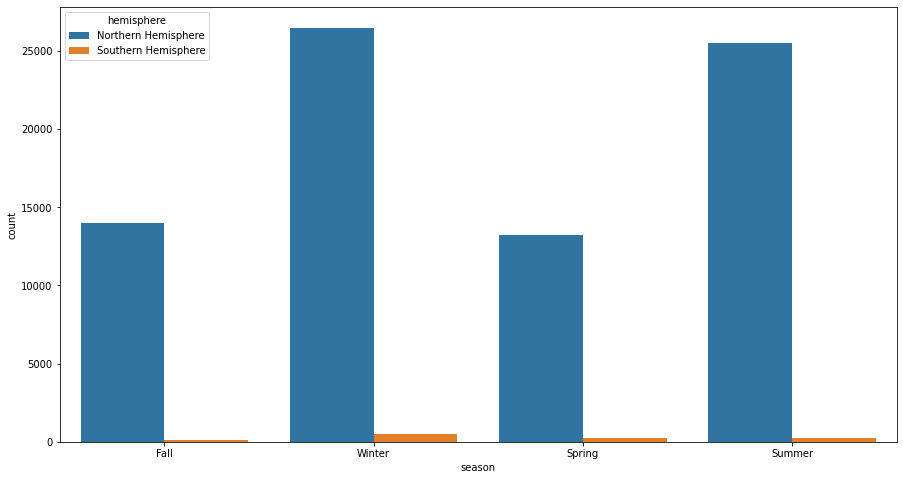

In [56]:
plt.figure(figsize=(15,8))
sns.countplot(x='season', hue='hemisphere', data=ufo_data)

In [57]:
print(ufo_data.latitude.max())
print(ufo_data.latitude.min())

72.7
-82.862752


In [58]:
resp_n = ufo_data[ufo_data['hemisphere'] == 'Northern Hemisphere']
resp_s = ufo_data[ufo_data['hemisphere'] == 'Southern Hemisphere']

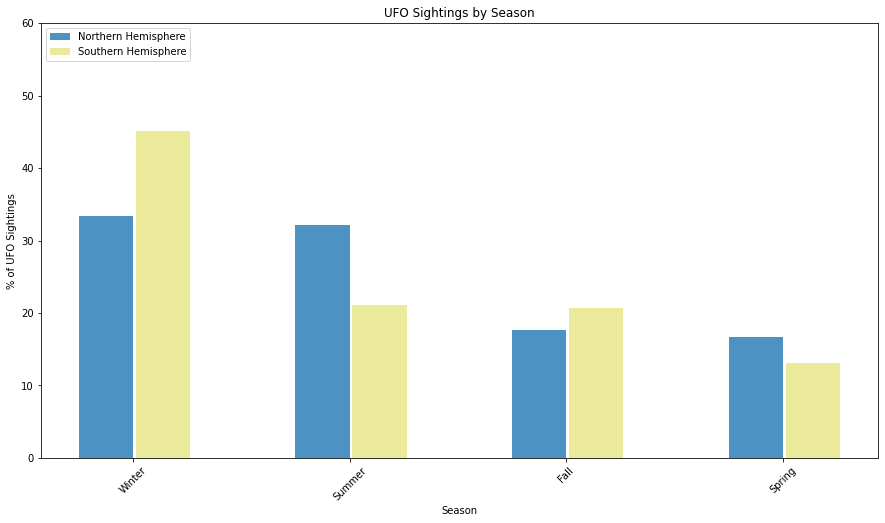

Northern Hemisphere:
 Winter    33.449099
Summer    32.200093
Fall      17.683089
Spring    16.667719
Name: season, dtype: float64
Southern Hemisphere:
 Winter    45.158287
Spring    21.135940
Summer    20.670391
Fall      13.035382
Name: season, dtype: float64


In [59]:
nsperc = resp_n['season'].value_counts() / len(resp_n) * 100
ssperc = resp_s['season'].value_counts() / len(resp_s) * 100

pos = list(range(len(nsperc)))
width = 0.25
fig, ax = plt.subplots(figsize = (15,8))

plt.bar(pos, nsperc, width, alpha = .7, color='#0064A9')
plt.bar([p + width*1.05 for p in pos], ssperc, width, alpha = .65, color='#E1E066')

ax.set_title('UFO Sightings by Season')
ax.set_xlabel('Season')
ax.set_ylabel('% of UFO Sightings')
ax.set_xticks([p + .5 * width for p in pos])
ax.set_xticklabels(nsperc.index)
plt.xticks(rotation=45)

plt.ylim([0, 60])
plt.legend(['Northern Hemisphere','Southern Hemisphere'], loc='upper left')
plt.show()
print('Northern Hemisphere:\n', nsperc)
print('Southern Hemisphere:\n',ssperc)

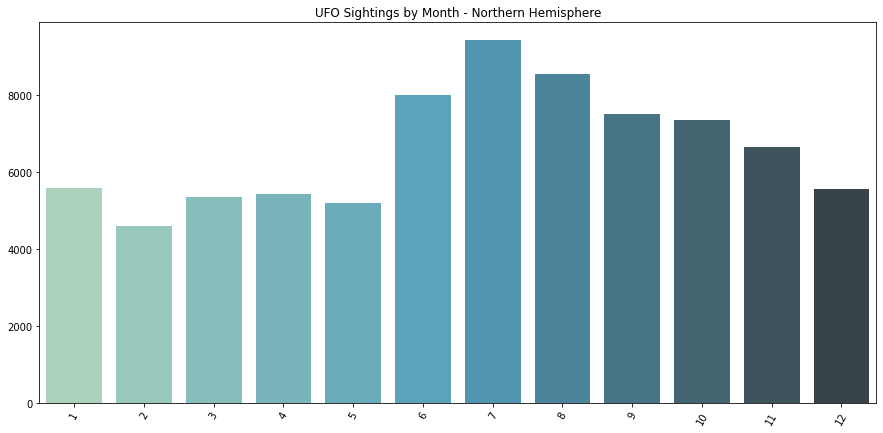

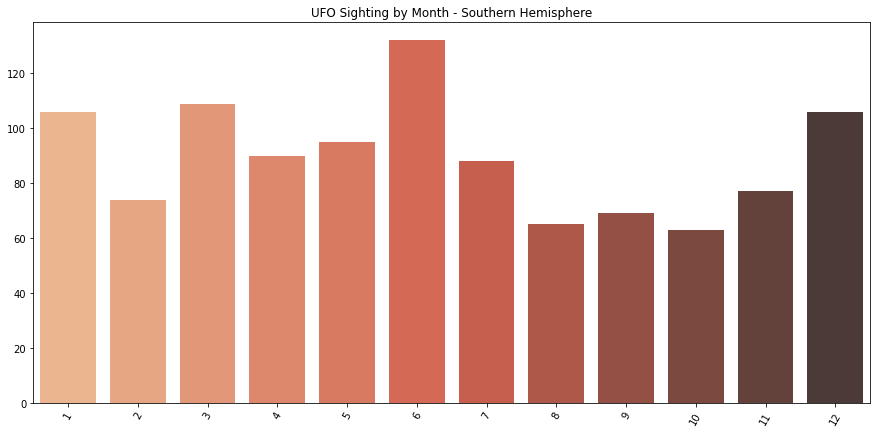

Top Months for UFO Sightings in N. Hemishpere:
7     9424
8     8562
6     8004
9     7511
10    7343
11    6659
Name: datetime, dtype: int64
Top Months for UFO Sightings in S. Hemisphere:
6     132
3     109
1     106
12    106
5      95
4      90
Name: datetime, dtype: int64


In [60]:
n_mon = resp_n['datetime'].dt.month
s_mon = resp_s['datetime'].dt.month

# N.MONTH #
monn_cts = n_mon.value_counts().sort_index()
monn_in = monn_cts.index 
monn_val = monn_cts.values

# S.MONTH #
mons_cts = s_mon.value_counts().sort_index()
mons_in = mons_cts.index
mons_val = mons_cts.values

plt.figure(figsize=(15,7))
plt.xticks(rotation = 60)
plt.title('UFO Sightings by Month - Northern Hemisphere')
sns.barplot(x=monn_in,y=monn_val, palette="GnBu_d")
plt.show()

plt.figure(figsize=(15,7))
plt.xticks(rotation = 60)
plt.title('UFO Sighting by Month - Southern Hemisphere')
sns.barplot(x=mons_in, y=mons_val, palette="OrRd_d")
plt.show()

print('Top Months for UFO Sightings in N. Hemishpere:')
print(n_mon.value_counts()[:6])
print('Top Months for UFO Sightings in S. Hemisphere:')
print(s_mon.value_counts()[:6])


In [61]:
import plotly.graph_objs as go
import plotly.offline as py


In [62]:
states_us = df[df.country == "us"]["state"].value_counts().index
states_ratio = df[df.country == "us"]["state"].value_counts().values
states_us = [i.upper() for i in states_us]

In [63]:
data = [
        dict(
        type='choropleth',
        locations = states_us,
        z = states_ratio,
        locationmode = 'USA-states',
        text = "times",
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Sight rates by states")
        )
        ]

layout = dict(
        title = 'UFO sight rates from USA',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
              )


fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [64]:
from pandas.plotting import scatter_matrix

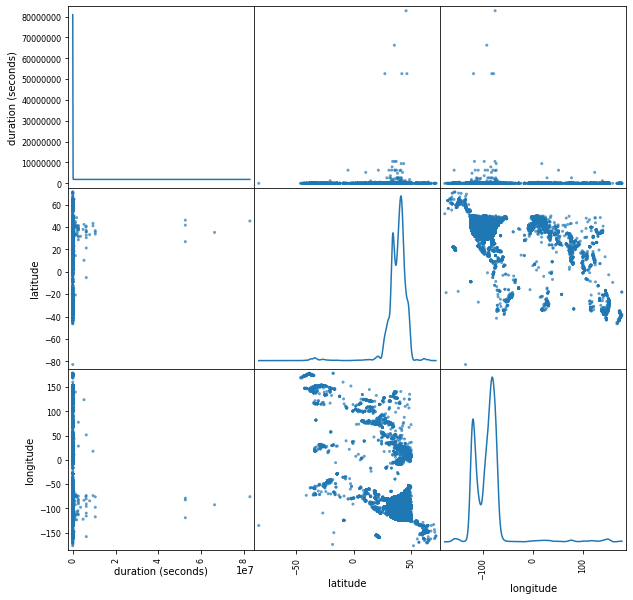

In [65]:
# from pandas.tools.plotting import scatter_matrix
stuff = scatter_matrix(df, alpha=0.7, figsize=(10,10), diagonal='kde')

In [66]:
df.head()

datetime          city state country     shape  duration (seconds)  \
0  10/10/1949 20:30    san marcos    tx      us  cylinder              2700.0   
1  10/10/1949 21:00  lackland afb    tx    None     light              7200.0   
2  10/10/1956 21:00          edna    tx      us    circle                20.0   
3  10/10/1960 20:00       kaneohe    hi      us     light               900.0   
4  10/10/1961 19:00       bristol    tn      us    sphere               300.0   

  duration (hours/min)                                           comments  \
0           45 minutes  This event took place in early fall around 194...   
1              1-2 hrs  1949 Lackland AFB&#44 TX.  Lights racing acros...   
2             1/2 hour  My older brother and twin sister were leaving ...   
3           15 minutes  AS a Marine 1st Lt. flying an FJ4B fighter/att...   
4            5 minutes  My father is now 89 my brother 52 the girl wit...   

  date posted   latitude   longitude  
0   4/27/2004  29.883055  -97.941109  
1  12/16/2005  29.384211  -98.581085  
2   1/17/2004  28.978333  -96.645836  
3   1/22/2004  21.418056 -157.803604  
4   4/27/2007  36.595001  -82.188889

Text(0.5, 1.0, 'State where UFO appeared')

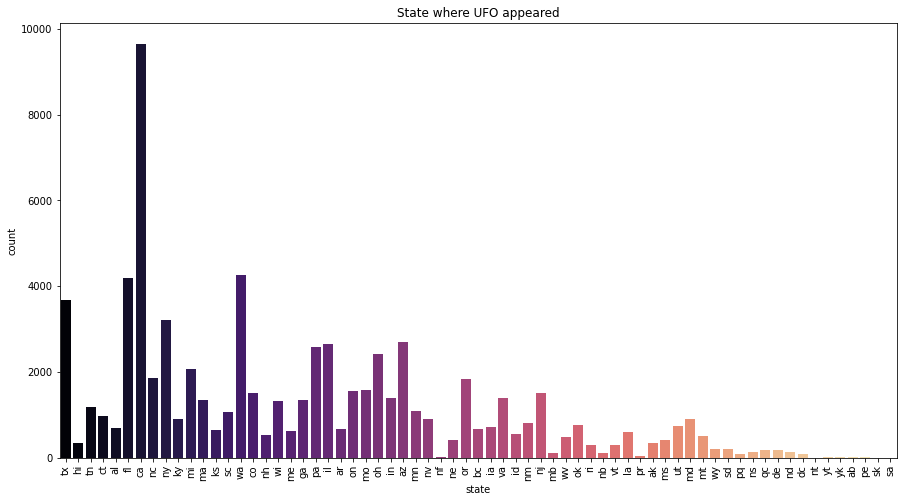

In [67]:
plt.figure(figsize=(15,8))
sns.countplot(x = 'state', data = df, palette = 'magma')
plt.xticks(rotation=90)
plt.title('State where UFO appeared')
# plt.show()

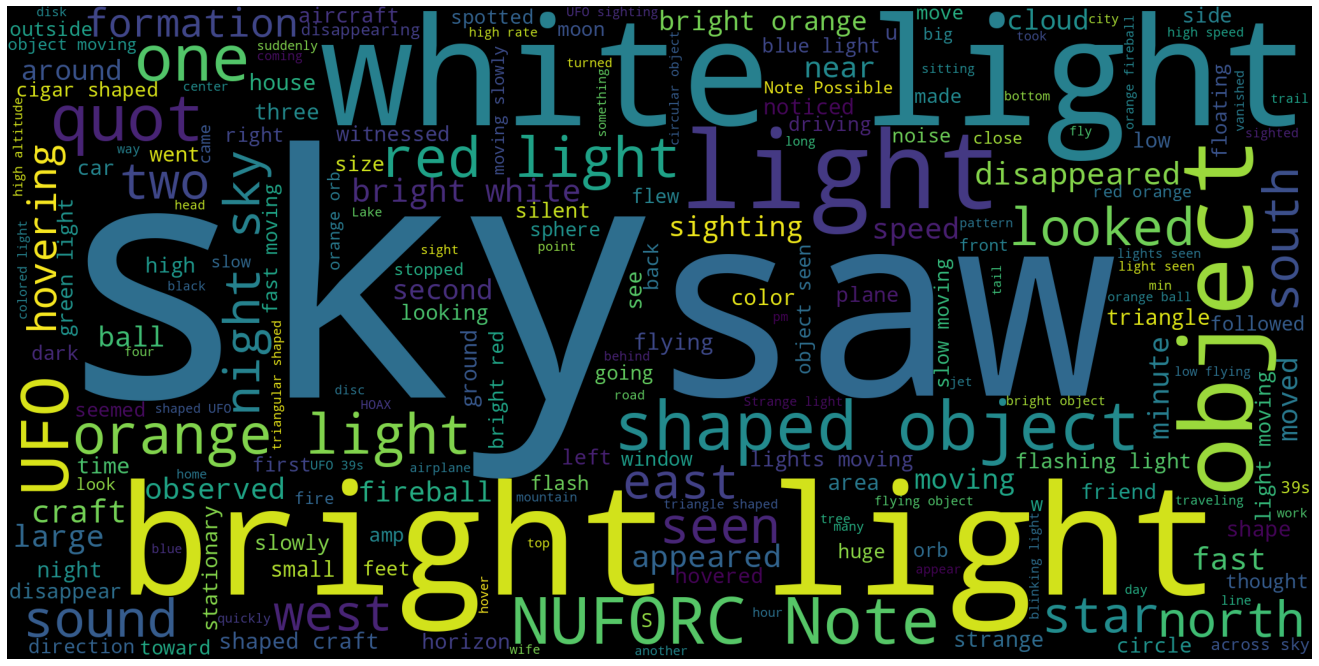

In [68]:
from wordcloud import WordCloud
words = [i for i in df.comments.dropna()]    
words = " ".join(words)
plt.subplots(figsize=(28,12))
wordcloud = WordCloud(background_color='black',
                          width=2048,
                          height=1024
                          ).generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('graph.png')

plt.show()

In [69]:
# df.datetime = 
pd.to_datetime(df.datetime, format='%Y/%m/%d HH:MM', errors='ignore')
# 10/10/1949 20:30

0        10/10/1949 20:30
1        10/10/1949 21:00
2        10/10/1956 21:00
3        10/10/1960 20:00
4        10/10/1961 19:00
               ...       
76804      9/9/2013 21:15
76805      9/9/2013 22:00
76806      9/9/2013 22:00
76807      9/9/2013 22:20
76808      9/9/2013 23:00
Name: datetime, Length: 76809, dtype: object

In [70]:
df.dtypes

datetime                 object
city                     object
state                    object
country                  object
shape                    object
duration (seconds)      float32
duration (hours/min)     object
comments                 object
date posted              object
latitude                float32
longitude               float32
dtype: object

In [71]:
from datetime import datetime
# pd.to_datetime(df['datetime'], format='%d/%m/%Y HH:MM')
df['datetime']= pd.to_datetime(df.datetime, format='%Y/%m/%d HH:MM', errors='ignore')


In [72]:
df.datetime.dtype

dtype('O')

### Linear Regression

In [73]:
import datetime

data = df.dropna()
data = data.reset_index(drop=True)
data = data[['shape','latitude','longitude','datetime','comments']]
data['datetime'] = pd.to_datetime(data.datetime, format='%Y/%m/%d HH:MM', errors='ignore')

# data['datetime'].apply(lambda x: pd.Timestamp(x).date())
data = data[(data['datetime'] <= '1/1/2017 20:30')]
# data[(data['datetime'] <= datetime.date(2017, 1, 1))]


    
cols = ['shape', 'latitude', 'longitude', 'datetime']
data['reports'] = data.groupby(cols).transform('count')
data['credibility'] = np.where(data['reports']>=2, 'High', 'Low')

In [74]:
#Define features (summaries) and labels (credibilities)
summaries = data['comments']
credibilities = data['credibility']

#Vectorize features, aka text summaries.
vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=5)
vectors = vectorizer.fit_transform(summaries)

f_train, f_test, l_train, l_test = train_test_split(vectors, credibilities, test_size = 0.3)
svm = LinearSVC(C=0.7, class_weight='balanced')
clf = CalibratedClassifierCV(svm)
clf.fit(f_train, l_train)


/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



CalibratedClassifierCV(base_estimator=LinearSVC(C=0.7, class_weight='balanced'))

In [75]:
"""Training Data Predictions."""
pred_train = clf.predict(f_train)
print(classification_report(l_train, pred_train))

              precision    recall  f1-score   support

        High       0.00      0.00      0.00         2
         Low       0.99      1.00      1.00       361

    accuracy                           0.99       363
   macro avg       0.50      0.50      0.50       363
weighted avg       0.99      0.99      0.99       363



/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [76]:
"""Testing Data Predictions."""
pred_test = clf.predict(f_test)
print(classification_report(l_test, pred_test))


              precision    recall  f1-score   support

        High       0.00      0.00      0.00         2
         Low       0.99      1.00      0.99       154

    accuracy                           0.99       156
   macro avg       0.49      0.50      0.50       156
weighted avg       0.97      0.99      0.98       156



/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [77]:
"""Using the model: Percent chance credibilities."""
fake = ["I saw a white flying saucer heading southeast while I was out with my dog.\
         It hovered for a bit before disappearing. I haven't told anyone else about it."] # I wrote this, haha...

real = ["My wife and I were walking our dogs on the south side of South Mountain\
        in the mountain park when we saw the ufo come over the mountain at low\
        altitude (500'appx) headed southbound.  It was s i l e n t and had 5 white\
        globes along the leading edge of a black triangle shaped object which blacked\
        out the stars and was about a mile wide."] # description from a sighting with multiple reports... 

def credibility(summary):
    """String needs to be in a list, e.g. [Description]"""
    s = vectorizer.transform(summary)
    y_proba = clf.predict_proba(s)
    prob = y_proba[0][0]*100
    if prob > 30.0: #50% too large since even mass sightings will be around 55-60%
        return print("High credibility: " + "%.2f" % (y_proba[0][0]*100) + "%")
    else:
        return print("Low credibility: " + "%.2f" % (y_proba[0][0]*100) + "%")

In [78]:
credibility(fake) #credibility percentage of a fake sighting
credibility(real) #credibility percentage of a real, mass sighting

Low credibility: 1.76%
Low credibility: 1.58%


### Decision Tree

In [79]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [80]:
data

shape   latitude   longitude        datetime  \
8909      disk  40.194721  -92.583054  1/1/1910 24:00   
9100     cigar  32.715279 -117.156387  1/1/1944 12:00   
9101      disk  40.418888  -80.589722  1/1/1956 05:30   
9102   unknown  32.783333  -96.800003  1/1/1957 21:00   
9103  fireball  33.816113 -102.557777  1/1/1958 22:00   
...        ...        ...         ...             ...   
9613     light  47.658890 -117.425003  1/1/2014 21:30   
9614    circle  39.878334  -75.093056  1/1/2014 22:00   
9615    circle  39.161945  -84.456947  1/1/2014 22:15   
9616  fireball  33.815834  -78.680275  1/1/2014 23:00   
9617     light  32.221668 -110.925835  1/1/2014 23:00   

                                               comments  reports credibility  
8909  Historical sighting (1903 - 1913) Northern Mis...        1         Low  
9100  A sighting of one silver or white enlongated c...        1         Low  
9101  My Uncle Sam was driving to work very early on...        1         Low  
9102  I was flying the first of 4 USAF aircraft on a...        1         Low  
9103  Green fire balls&#44 Texas Panhandle&#44 late ...        1         Low  
...                                                 ...      ...         ...  
9613  Orange/red light in the sky moving from east t...        1         Low  
9614    Circular craft spotted in Mount Ephraim&#44 NJ.        1         Low  
9615  Westside of Cincinnati&#44 bright red and blue...        1         Low  
9616  Chinese lanterns with orange glow very popular...        1         Low  
9617                                   Floating lights.        1         Low  

[519 rows x 7 columns]

In [81]:
# data.loc[data.credibility == 'Low', 'credibility'] = 0

In [82]:
data.groupby([ 'credibility', 'shape']).sum()

latitude     longitude  reports
credibility shape                                        
High        light        65.430557   -234.312775        4
            triangle     65.589447   -233.923340        4
Low         changing    591.188354  -1608.268066       17
            chevron      72.639450   -218.890289        2
            cigar       261.366394   -661.161682        7
            circle     2599.766846  -6791.067383       71
            cone        128.202774   -265.082764        3
            cross        36.798332    -81.682503        1
            cylinder    297.411682   -728.185547        8
            diamond     253.761673   -654.448059        7
            disk        943.650574  -2540.030762       26
            egg         204.933609   -572.380249        6
            fireball   1905.305786  -5085.644531       54
            flash       213.667221   -580.087769        6
            formation   974.459717  -2849.021240       26
            light      4195.553711 -11353.952148      112
            other       887.549744  -2440.968994       23
            oval        873.378906  -2301.865234       23
            rectangle   149.608887   -443.726959        4
            sphere     1681.403320  -4828.032227       46
            teardrop     75.687775   -204.756943        2
            triangle   1286.771118  -3409.256348       35
            unknown    1280.974731  -3475.862549       36

In [83]:
data

shape   latitude   longitude        datetime  \
8909      disk  40.194721  -92.583054  1/1/1910 24:00   
9100     cigar  32.715279 -117.156387  1/1/1944 12:00   
9101      disk  40.418888  -80.589722  1/1/1956 05:30   
9102   unknown  32.783333  -96.800003  1/1/1957 21:00   
9103  fireball  33.816113 -102.557777  1/1/1958 22:00   
...        ...        ...         ...             ...   
9613     light  47.658890 -117.425003  1/1/2014 21:30   
9614    circle  39.878334  -75.093056  1/1/2014 22:00   
9615    circle  39.161945  -84.456947  1/1/2014 22:15   
9616  fireball  33.815834  -78.680275  1/1/2014 23:00   
9617     light  32.221668 -110.925835  1/1/2014 23:00   

                                               comments  reports credibility  
8909  Historical sighting (1903 - 1913) Northern Mis...        1         Low  
9100  A sighting of one silver or white enlongated c...        1         Low  
9101  My Uncle Sam was driving to work very early on...        1         Low  
9102  I was flying the first of 4 USAF aircraft on a...        1         Low  
9103  Green fire balls&#44 Texas Panhandle&#44 late ...        1         Low  
...                                                 ...      ...         ...  
9613  Orange/red light in the sky moving from east t...        1         Low  
9614    Circular craft spotted in Mount Ephraim&#44 NJ.        1         Low  
9615  Westside of Cincinnati&#44 bright red and blue...        1         Low  
9616  Chinese lanterns with orange glow very popular...        1         Low  
9617                                   Floating lights.        1         Low  

[519 rows x 7 columns]

In [84]:
# X = data['credibility'] # Features
# y = data['reports'] # Target variable

In [85]:
features = data.drop(columns = 'credibility')
target = data['shape']

In [86]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
for col in data.columns:
    features[col] = labelencoder.fit_transform(data[col])

In [87]:
features

shape  latitude  longitude  datetime  comments  reports  credibility
8909      8       274        184         0       182        0            1
9100      2        82        101         1        87        0            1
9101      8       279        310         2       249        0            1
9102     20        88        164         3       199        0            1
9103     10       112        151         4       176        0            1
...     ...       ...        ...       ...       ...      ...          ...
9613     13       374         92       369       311        0            1
9614      3       265        363       370       132        0            1
9615      3       252        246       371       456        0            1
9616     10       111        339       372       130        0            1
9617     13        71        137       372       160        0            1

[519 rows x 7 columns]

In [88]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1) # 70% training and 30% test

In [89]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)


In [90]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

from sklearn.metrics import classification_report

print (classification_report(y_test,y_pred)) # seems to be overfitted as it has almost 100% F1 scores

              precision    recall  f1-score   support

    changing       1.00      1.00      1.00         6
     chevron       1.00      1.00      1.00         1
       cigar       1.00      1.00      1.00         1
      circle       1.00      1.00      1.00        28
        cone       1.00      1.00      1.00         1
    cylinder       1.00      1.00      1.00         3
     diamond       1.00      1.00      1.00         1
        disk       1.00      1.00      1.00         4
    fireball       1.00      1.00      1.00        15
   formation       1.00      1.00      1.00         9
       light       1.00      1.00      1.00        38
       other       1.00      1.00      1.00         5
        oval       1.00      1.00      1.00         5
   rectangle       1.00      1.00      1.00         1
      sphere       1.00      1.00      1.00        13
    triangle       1.00      1.00      1.00        10
     unknown       1.00      1.00      1.00        15

    accuracy              

In [91]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=10, 
                                    n_repeats=3, 
                                    random_state=999)

from sklearn.model_selection import cross_val_score
print(cross_val_score(clf, X_train, y_train, cv=cv_method)) 

from statistics import mean 
mean(cross_val_score(clf, X_train, y_train,cv=cv_method))



/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



[1.         0.97297297 0.97297297 1.         1.         1.
 1.         1.         0.97222222 1.         1.         1.
 0.97297297 1.         1.         1.         1.         1.
 0.97222222 1.         1.         0.97297297 0.97297297 1.
 1.         1.         1.         1.         0.97222222 1.        ]


/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



0.9926926926926927

In [92]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
score

1.0

In [93]:
clf = DecisionTreeClassifier()

fit = clf.fit(X_train,y_train)

y_pred= fit.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  0, 28,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 38,  0,  0,  0,  0,  0,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  

In [94]:
print (classification_report(y_test,y_pred))   # As Expected high accuracy --Overfitting/more fitting than learning

              precision    recall  f1-score   support

    changing       1.00      1.00      1.00         6
     chevron       1.00      1.00      1.00         1
       cigar       1.00      1.00      1.00         1
      circle       1.00      1.00      1.00        28
        cone       1.00      1.00      1.00         1
    cylinder       1.00      1.00      1.00         3
     diamond       1.00      1.00      1.00         1
        disk       1.00      1.00      1.00         4
    fireball       1.00      1.00      1.00        15
   formation       1.00      1.00      1.00         9
       light       1.00      1.00      1.00        38
       other       1.00      1.00      1.00         5
        oval       1.00      1.00      1.00         5
   rectangle       1.00      1.00      1.00         1
      sphere       1.00      1.00      1.00        13
    triangle       1.00      1.00      1.00        10
     unknown       1.00      1.00      1.00        15

    accuracy              

In [95]:
#Cross-Validation

from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=10, 
                                    n_repeats=3, 
                                    random_state=999)

from sklearn.model_selection import cross_val_score
print(cross_val_score(clf, X_train, y_train, cv=cv_method)) 

from statistics import mean 
mean(cross_val_score(clf, X_train, y_train,cv=cv_method))

/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



[1.         0.97297297 0.97297297 1.         1.         1.
 1.         0.97222222 0.97222222 1.         1.         1.
 0.97297297 1.         1.         1.         1.         1.
 0.97222222 1.         1.         0.97297297 0.97297297 1.
 1.         1.         1.         1.         0.97222222 1.        ]


/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/Users/mintu/opt/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



0.9936186186186187

In [96]:
whos

Variable                      Type                       Data/Info
------------------------------------------------------------------
CalibratedClassifierCV        type                       <class 'sklearn.calibrati<...>.CalibratedClassifierCV'>
Column                        type                       <class 'pyspark.sql.column.Column'>
DataFrame                     type                       <class 'pyspark.sql.dataframe.DataFrame'>
DataType                      type                       <class 'pyspark.sql.types.DataType'>
DateType                      DataTypeSingleton          <class 'pyspark.sql.types.DateType'>
DecisionTreeClassifier        ABCMeta                    <class 'sklearn.tree._cla<...>.DecisionTreeClassifier'>
F                             module                     <module 'pyspark.sql.func<...>yspark/sql/functions.py'>
IntegerType                   DataTypeSingleton          <class 'pyspark.sql.types.IntegerType'>
LabelEncoder                  type                

states_pop                    Series                     al     4872725.0\nak     <...> 584447.0\ndtype: float64
states_ratio                  ndarray                    52: 52 elems, type `int64`, 416 bytes
states_sights                 Series                     ca    8912\nwa    3966\nf<...>Name: state, dtype: int64
states_us                     list                       n=52
statespop                     dict                       n=52
stddev                        function                   <function stddev at 0x7fbf5972e0d0>
stddev_pop                    function                   <function stddev_pop at 0x7fbf5972e1f0>
stddev_samp                   function                   <function stddev_samp at 0x7fbf5972e160>
struct                        function                   <function struct at 0x7fbf59730c10>
stuff                         ndarray                    3x3: 9 elems, type `object`, 72 bytes
substring                     function                   <function substring at